In [1]:
import os
import numpy as np
import dapy.utils.pou as pou
import dapy.utils.localisation as loc
import dapy.inference as da
import dapy.ot as ot
import dapy.inference.pf as pf
from dapy.models.navier_stokes import NavierStokes2dModel
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
import seaborn as sns
%matplotlib inline
sns.set_style('white')
rc('animation', html='html5')

In [2]:
# enable pyfftw caching of FFT plans
import pyfftw.interfaces.cache as cache
cache.enable()
cache.set_keepalive_time(1.)

## Model

The incompressible Navier-Stokes equations describe the time-evolution of the velocity field of a fluid as the following system of partial differential equations

\begin{equation}
  \frac{\textrm{d} \boldsymbol{u}(\boldsymbol{s}, t)}{\mathrm{d} t} =
  \nu \nabla \cdot \nabla \boldsymbol{u}(\boldsymbol{s}, t) - 
  \left(\boldsymbol{u}(\boldsymbol{s},t) \cdot \nabla\right) \boldsymbol{u}(\boldsymbol{s},t) -
  \nabla w(\boldsymbol{s}, t)  + \boldsymbol{f}(\boldsymbol{s},t)
\end{equation}

with in two-dimesions $\boldsymbol{u}(\boldsymbol{s}, t) = \left(u_0(\boldsymbol{s},t),u_1(\boldsymbol{s},t)\right)^{\rm T} : \mathcal{S} \times \mathcal{T} \to \mathbb{R}^2$ the velocity field, $\mathbf{s} = (s_0, s_1)^{\rm T} \in \mathcal{S}$ the spatial coordinate, $t \in \mathcal{T}$ the time coordinate, $\nu$ the kinematic viscosity, $\nabla = \left( \frac{\partial}{\partial s_0},~\frac{\partial}{\partial s_1}\right)^{\rm T}$ the del partial derivative operator, $w(\boldsymbol{s},t) \in \mathbb{R}^{+}$ is the specific thermodynamic work field and $\boldsymbol{f}(\boldsymbol{s},t) \in \mathbb{R}^2$ is an external force field. The flow is further subject to the incompressibility condition (equivalently requiring a divergence-free flow)

\begin{equation}
  \nabla \cdot \boldsymbol{u}(\boldsymbol{s},t) = 0 ~~\forall \boldsymbol{s} \in \mathcal{S},~t \in \mathcal{T}.
\end{equation}

In the absence of an external force field, the dynamics consist of a combination of the diffusive $\nu \nabla \cdot \nabla \boldsymbol{u}(\boldsymbol{s}, t)$ term which models viscous diffusion and the (self-)advection term  $\left(\boldsymbol{u}(\boldsymbol{s},t) \cdot \nabla\right) \boldsymbol{u}(\boldsymbol{s},t)$, with the specific work field $w(\boldsymbol{s},t)$ being implicitly defined by solving for the incompressibility condition.

If we define the scalar vorticity as the curl of the velocity field 
\begin{equation}
  v(\boldsymbol{s},t) = \nabla \times \boldsymbol{u}(\boldsymbol{s},t) = 
  \frac{\partial u_2(\boldsymbol{s},t)}{\partial s_1} - \frac{\partial u_1(\boldsymbol{s},t)}{\partial s_2}
\end{equation}
then by taking the curl of the incompressible Navier-Stokes equation we can derive the vorticity transport equation
\begin{equation}
  \frac{\textrm{d} v(\boldsymbol{s}, t)}{\mathrm{d} t} =
  \nu \nabla \cdot \nabla v(\boldsymbol{s}, t) - 
  \left(\boldsymbol{u}(\boldsymbol{s},t) \cdot \nabla\right) v(\boldsymbol{s},t) +
  g(\boldsymbol{s},t)
\end{equation}
where $g(\boldsymbol{s},t) = \nabla \times \boldsymbol{f}(\boldsymbol{s},t)$. Reparameterising the velocity field in terms of the vorticity removes the need to constrain the dynamics to the space of divergence-free velocity fields.

For computational simplicity, here we consider simulation on a two-dimensional torus, i.e. with periodic boundary conditions. The spatial domain is defined as $\mathcal{S} = [-1,1]^2$ with the top and bottom edges, and left and right edges identified with each other. The spatial domain is discretised on a rectilinear grid of $M^2$ points

\begin{equation}
  \boldsymbol{s}^{(i,j)} = \left(\frac{i}{M},\frac{j}{M}\right) 
  ~~\forall i,j \in \lbrace 0 \dots M-1 \rbrace^2.
\end{equation}

Defining the following notation for the spatially discretised vorticity field

\begin{equation}
   v^{(i,j)}(t) = v(\boldsymbol{s}^{(i,j)}, t)
  \qquad
  \forall i,j \in \lbrace 0 \dots M-1 \rbrace^2
\end{equation}

then the overall system state $\boldsymbol{z}(t) \in \mathbb{R}^{M^2}$ is defined as the flattened discretised vorticity field (dropping the time-dependence for clarity)

\begin{equation}
  \boldsymbol{z} = \left( 
    v^{(0,0)}, v^{(0,1)} \cdots v^{(0,M)}, v^{(1,0)} \cdots v^{(M,M)}
  \right)^{\rm T}.
\end{equation}

The observations $\boldsymbol{x}(t) \in \mathbb{R}^{(M / S)^2}$ are assumed to correspond to a noisy spatial factor $S$ subsampling of the vorticity field i.e.

\begin{equation}
  \boldsymbol{x} = \left( 
    v^{(0,0)}, v^{(0,S)}, v^{(0,2S)} \cdots v^{(0,M)}, v^{(S,0)} \cdots v^{(M,M)}
  \right)^{\rm T} + \sigma_x \boldsymbol{n}
  \quad\textrm{with}\quad \boldsymbol{n}(t) \sim \mathcal{N}(\mathbf{0},\mathbf{I}).
\end{equation}

An operator splitting method is used to simulate the dynamics at discrete time steps $t = \delta t, 2\delta t, \dots$, with separate schemes used to model the diffusion and advection terms. The advection terms are simulated in the spatial domain using a semi-Lagrangian scheme with backward-forward error correction for second-order accuracy [1]. The diffusion term is simulated in the spectral domain by approximating the spatial derivatives (Laplacian) using a FFT based Fourier spectral method and exactly solving the resulting linear system in spectral space for a fixed time-step. The forcing term on the vorticity $g(\boldsymbol{s},t)$ is taken to be a stochastic Gaussian process, white in time and correlated in space, with the forcing term simulate by adding a spatially correlated Gaussian field scaled by $\sqrt{\delta t}$. 


### References

  1. Kim, ByungMoon, Yingjie Liu, Ignacio Llamas, and Jarek Rossignac. FlowFixer: using BFECC for fluid simulation.  
     Proceedings of the First Eurographics conference on Natural Phenomena. Eurographics Association, 2005.

In [3]:
n_steps = 500
seed = 20180211
rng = np.random.RandomState(seed)
params = {
    'grid_shape': (128, 128),
    'visc_diff_coeff': 1e-4,
    'vort_noise_length_scale': 1e-3,
    'init_vort_ampl_scale': 5e-1,
    'vort_noise_ampl_scale': 5e-2,
    'init_vort_int_time': 50.,
    'obser_noise_std': 1.,
    'dt': 0.01,
    'n_steps_per_update': 20,
    'grid_size': (2, 2),
    'obs_subsample': 8,
    'max_n_thread': 2
}
locals().update(params)
model = NavierStokes2dModel(rng=rng, **params)

## Helper function for animating fields

In [4]:
def extract_vorticity(z, grid_shape):
    return z.reshape(grid_shape)
    
def extract_velocity(z, grid_shape):
    return model.integrator.velocity_from_vorticity(z.reshape(grid_shape))

def animate_fields(state_seqs, grid_shape, fig_size, cmap='inferno', 
                   vel_skip=8, vmin=None, vmax=None, interval=50, 
                   save_path=None, save_dpi=72, titles=None):
    n_seq = len(state_seqs)
    grid_points = np.array(
        np.meshgrid(np.linspace(0, 1, grid_shape[0]), 
                    np.linspace(0, 1, grid_shape[1]), indexing='ij')
    )
    grid_box = [
        grid_points[0, 0, 0], grid_points[0, -1, -1],
        grid_points[1, 0, 0], grid_points[1, -1, -1]]
    fig, axes = plt.subplots(nrows=1, ncols=n_seq, figsize=fig_size,
                             subplot_kw=dict(xticks=[], yticks=[]), squeeze=True)
    ims, qus = [], []
    for state_seq, ax in zip(state_seqs, axes):
        if state_seq.shape[-1] == grid_shape[0] * grid_shape[1]:
            vort = extract_vorticity(state_seq[-1], grid_shape)
            ims.append(ax.imshow(
                vort.T, cmap=cmap, origin='lower', extent=grid_box, 
                vmin=vmin, vmax=vmax))
            vel = extract_velocity(state_seq[-1], grid_shape)
            qus.append(ax.quiver(
                grid_points[0, ::vel_skip, ::vel_skip], 
                grid_points[1, ::vel_skip, ::vel_skip],
                vel[0, ::vel_skip, ::vel_skip], 
                vel[1, ::vel_skip, ::vel_skip], 
                color='white', angles='xy'))
        else:
            vort = extract_vorticity(state_seq[-1], 
                                   (grid_shape[0] // obs_subsample, 
                                    grid_shape[1] // obs_subsample))
            ims.append(ax.imshow(
                vort.T, cmap=cmap, origin='lower', extent=grid_box, 
                vmin=vmin, vmax=vmax))
            qus.append(None)
    
    def init():
        for state_seq, im, qu in zip(state_seqs, ims, qus):
            if qu is not None:
                vort = extract_vorticity(state_seq[0], grid_shape)
                im.set_data(vort.T)
                vel = extract_velocity(state_seq[0], grid_shape)
                qu.set_UVC(vel[0, ::vel_skip, ::vel_skip], 
                           vel[1, ::vel_skip, ::vel_skip])
            else:
                vort = extract_vorticity(state_seq[0], 
                       (grid_shape[0] // obs_subsample, 
                        grid_shape[1] // obs_subsample))
                im.set_data(vort.T)
        return ims + [q for q in qus if q is not None]
    
    def animate(i):
        for state_seq, im, qu in zip(state_seqs, ims, qus):
            if qu is not None:
                vort = extract_vorticity(state_seq[i], grid_shape)
                im.set_data(vort.T)
                vel = extract_velocity (state_seq[i], grid_shape)
                qu.set_UVC(vel[0, ::vel_skip, ::vel_skip], 
                           vel[1, ::vel_skip, ::vel_skip])
            else:
                vort = extract_vorticity(state_seq[i], 
                       (grid_shape[0] // obs_subsample, 
                        grid_shape[1] // obs_subsample))
                im.set_data(vort.T)
        return ims + [q for q in qus if q is not None]
    
    for ax, title in zip(axes, titles):
        ax.set_title(title)
        
    fig.tight_layout()
        
    plt.close(fig)
    
    anim = animation.FuncAnimation(
        fig=fig, func=animate, init_func=init, frames=n_steps, 
        interval=interval, blit=True)
    
    if save_path:
        anim.save(save_path, fps=1000 // interval, extra_args=['-vcodec', 'libx264'], 
                  dpi=save_dpi)
        html = HTML('<video controls autoplay><source src="{0}" type="video/mp4">'
                    '</video>'.format(save_path))
        return anim, html
    else:
        return anim

## Generate data from model

In [5]:
z_reference, x_reference = model.generate(n_steps)

Generating: 100%|██████████| 499/499 [00:43<00:00, 11.37observation/s]


In [6]:
if not os.path.exists('videos'):
    os.makedirs('videos')
base_file_path = os.path.join(
    'videos', 'navier-stokes-2d-{0}x{1}'.format(*grid_shape))

In [7]:
anim, html = animate_fields(
    [z_reference, x_reference], 
    grid_shape, (12, 6), vmin=-3, vmax=3,
    save_path=base_file_path + '-simulation.mp4',
    titles=['Unobserved vorticity and velocity fields',
            'Observed noisy subsampled vorticity field'])
html

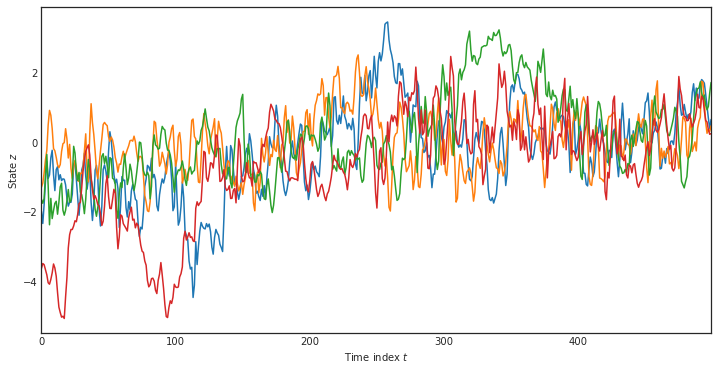

In [8]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(z_reference[:, :model.dim_z:model.dim_z // 4])
ax.set_xlabel('Time index $t$')
ax.set_ylabel('State $z$')
_ = ax.set_xlim(0, n_steps - 1)

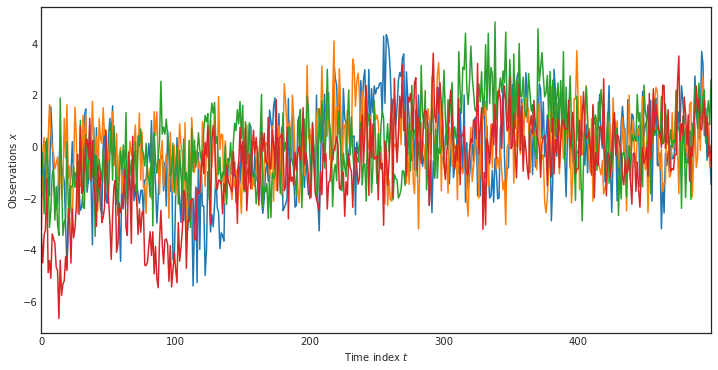

In [9]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(x_reference[:, :model.dim_x:model.dim_x // 4])
ax.set_xlabel('Time index $t$')
ax.set_ylabel('Observations $x$')
_ = ax.set_xlim(0, n_steps - 1)

## Infer state from observations

In [10]:
def plot_results(results, dim_indices, z_reference=None, 
                 plot_traces=False, plot_region=True, 
                 trace_skip=1, trace_alpha=0.25):
    print('Mean RMSE: {0:.3f}'.format(
          np.mean((results['z_mean_seq'] - z_reference)**2)**0.5))
    n_index = len(dim_indices)
    fig, axes = plt.subplots(nrows=n_index, ncols=1, sharex=True, 
                             figsize=(12, n_index * 3))
    for i, ax in zip(dim_indices, axes):
        ax.plot(results['z_mean_seq'][:, i], 'g-', lw=1)
        if plot_region:
            ax.fill_between(
                np.arange(n_steps),
                results['z_mean_seq'][:, i] - 3 * results['z_std_seq'][:, i],
                results['z_mean_seq'][:, i] + 3 * results['z_std_seq'][:, i],
                alpha=0.25, color='g'
            )
        if plot_traces:
            ax.plot(results['z_particles_seq'][:, ::trace_skip, i], 
                    'r-', lw=0.25, alpha=trace_alpha)
        if z_reference is not None:
            ax.plot(z_reference[:, i], 'k--')
        ax.set_ylabel('State at grid point {0}'.format(i))
    ax.set_xlabel('Time index $t$')
    fig.tight_layout()
    return fig, axes

In [11]:
state_grid_coords = (
    np.mgrid[:grid_shape[0], :grid_shape[1]] + 0.5
) * model.integrator.cell_size[:, None, None]
obser_grid_coords = state_grid_coords[
    :, ::obs_subsample, ::obs_subsample].reshape((2, -1)).T
state_grid_coords = state_grid_coords.reshape((2, -1)).T
state_grid_size = model.integrator.grid_size
localisation_radius = 0.125

### Local ensemble Kalman filter

In [12]:
localisation_func = loc.PeriodicLocalisationFunction(
    state_grid_coords, obser_grid_coords, state_grid_size,
    localisation_radius, use_cache=True)

In [13]:
letkf = da.LocalEnsembleTransformKalmanFilter(
    model.init_state_sampler, model.next_state_sampler, model.observation_func,
    model.obser_noise_std * np.ones(model.dim_x), model.dim_z, localisation_func, 1., rng)

In [14]:
results_letkf = letkf.filter(x_reference, 40)

Filtering: 100%|██████████| 500/500 [1:25:24<00:00, 10.25s/observation]


Mean RMSE: 0.731


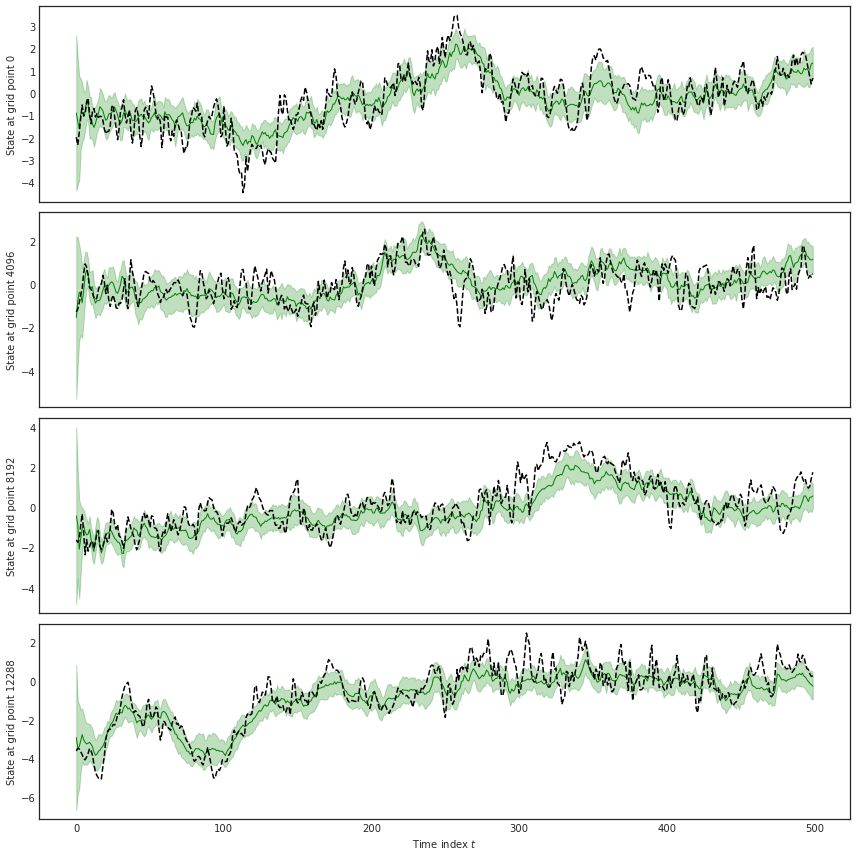

In [15]:
fig, axes = plot_results(
    results_letkf, range(0, model.dim_z, model.dim_z // 4), z_reference)

In [16]:
anim, html = animate_fields(
    [z_reference, x_reference, results_letkf['z_mean_seq']], 
    grid_shape, (12, 4), vmin=-3, vmax=3,
    save_path=base_file_path + '-letkf.mp4',
    titles=['Unobserved vorticity and velocity fields',
            'Observed noisy subsampled vorticity field',
            'Estimated vorticity and velocity fields'])
html

### Local ensemble transform particle filter

In [17]:
localisation_func = loc.PeriodicLocalisationFunction(
    state_grid_coords, obser_grid_coords, state_grid_size,
    localisation_radius, use_cache=True)

In [18]:
letpf = da.LocalEnsembleTransformParticleFilter(
    model.init_state_sampler, model.next_state_sampler, rng, model.observation_func,
    model.obser_noise_std * np.ones(model.dim_z), model.dim_z, localisation_func,
    ot_solver=ot.solve_optimal_transport_exact)

In [19]:
results_letpf = letpf.filter(x_reference, 40)

Filtering: 100%|██████████| 500/500 [1:23:08<00:00,  9.98s/observation]


Mean RMSE: 0.441


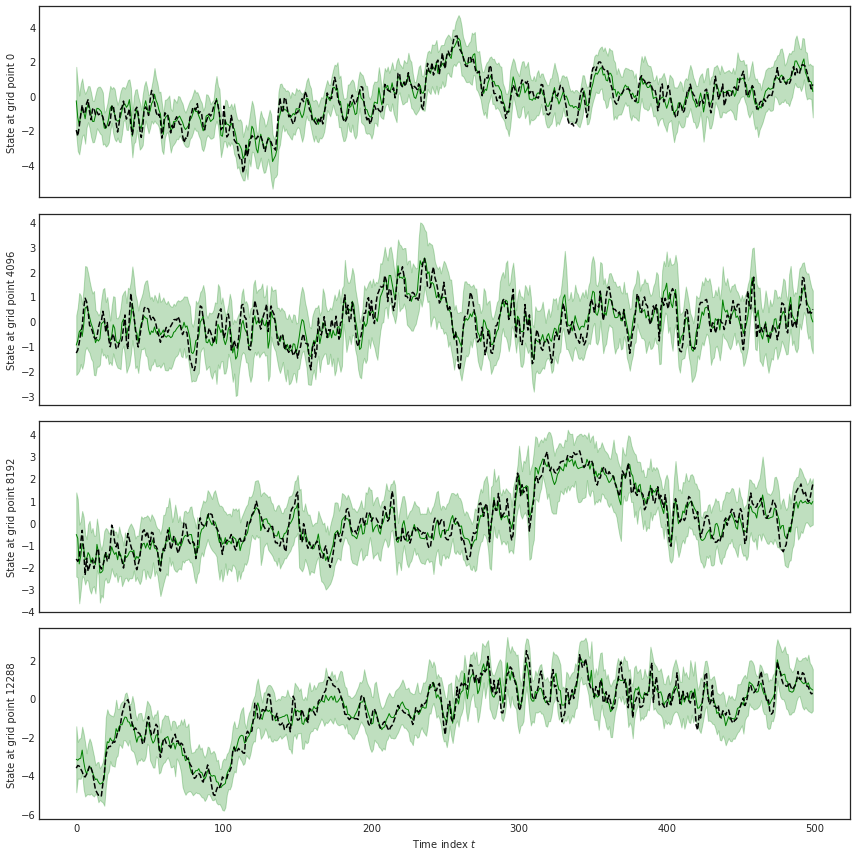

In [20]:
fig, axes = plot_results(
    results_letpf, range(0, model.dim_z, model.dim_z // 4), z_reference)

In [21]:
anim, html = animate_fields(
    [z_reference, x_reference, results_letpf['z_mean_seq']], 
    grid_shape, (12, 4), vmin=-3, vmax=3,
    save_path=base_file_path + '-letpf.mp4',
    titles=['Unobserved vorticity and velocity fields',
            'Observed noisy subsampled vorticity field',
            'Estimated vorticity and velocity fields'])
html

## Scalable localised ensemble transport filter

In [22]:
def log_likelihood_per_obs_loc(z_forecast, x_observed, time_index):
    x_forecast = model.observation_func(z_forecast, time_index)
    return -0.5 * (
        (x_forecast - x_observed[None])**2 / obser_noise_std**2)

In [24]:
ot_solver = ot.solve_optimal_transport_exact_batch
ot_solver_params = {'max_iter': 100000, 'n_thread': 4}
localisation_kernel = loc.PeriodicLocalisationFunction(
    obser_grid_coords, state_grid_coords, state_grid_size,
    localisation_radius, use_cache=True)

### Per grid-point PoU

In [25]:
pou_basis = pou.PerGridPointPartitionOfUnityBasis(grid_shape[0] * grid_shape[1])
sletpf_pg = pf.PouLocalEnsembleTransportParticleFilter(
    model.init_state_sampler, model.next_state_sampler, rng,
    log_likelihood_per_obs_loc, localisation_kernel, pou_basis,
    ot_solver, ot_solver_params)

In [26]:
results_sletpf_pg = sletpf_pg.filter(x_reference, 40, False)

Filtering: 100%|██████████| 500/500 [54:54<00:00,  6.59s/observation]


Mean RMSE: 0.441


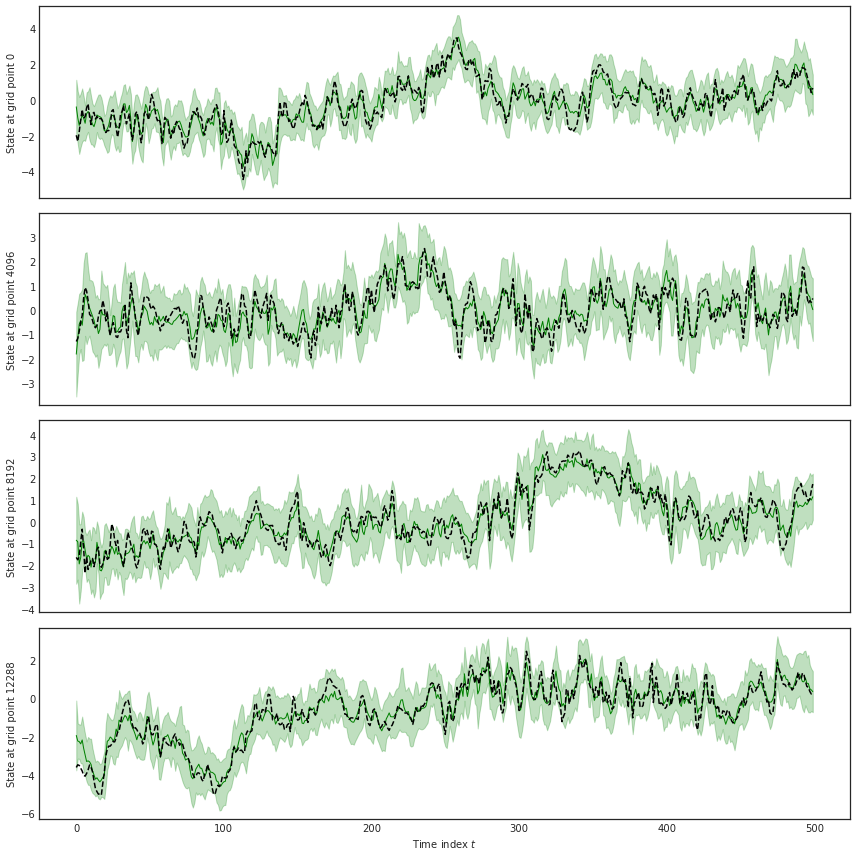

In [27]:
fig, axes = plot_results(
    results_sletpf_pg, range(0, model.dim_z, model.dim_z // 4), z_reference)

In [28]:
anim, html = animate_fields(
    [z_reference, x_reference, results_sletpf_pg['z_mean_seq']], 
    grid_shape, (12, 4), vmin=-3, vmax=3,
    save_path=base_file_path + '-sletpf-pg.mp4',
    titles=['Unobserved vorticity and velocity fields',
            'Observed noisy subsampled vorticity field',
            'Estimated vorticity and velocity fields'])
html

### Block PoU (4x4)

In [29]:
pou_basis = pou.Blocked2dPartitionOfUnityBasis(grid_shape, (4, 4))
sletpf_bl4 = pf.PouLocalEnsembleTransportParticleFilter(
    model.init_state_sampler, model.next_state_sampler, rng,
    log_likelihood_per_obs_loc, localisation_kernel, pou_basis,
    ot_solver, ot_solver_params)

In [30]:
results_sletpf_bl4 = sletpf_bl4.filter(x_reference, 40, False)

Filtering: 100%|██████████| 500/500 [35:54<00:00,  4.31s/observation]


Mean RMSE: 0.831


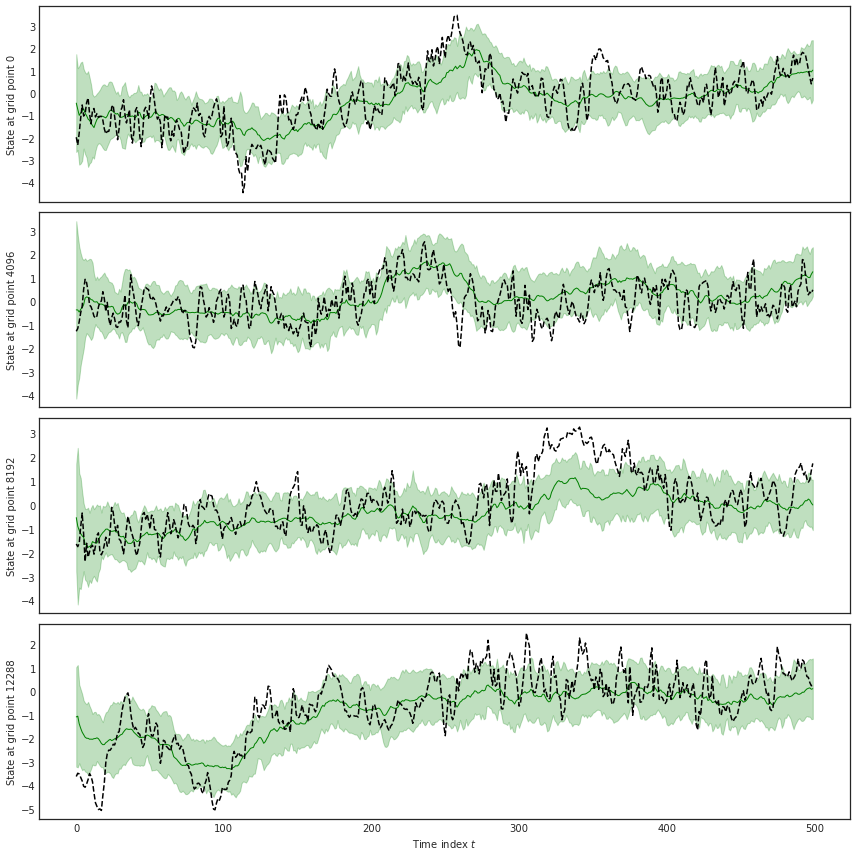

In [31]:
fig, axes = plot_results(
    results_sletpf_bl4, range(0, model.dim_z, model.dim_z // 4), z_reference)

In [32]:
anim, html = animate_fields(
    [z_reference, x_reference, results_sletpf_bl4['z_mean_seq']], 
    grid_shape, (12, 4), vmin=-3, vmax=3,
    save_path=base_file_path + '-sletpf-bl-4x4.mp4',
    titles=['Unobserved vorticity and velocity fields',
            'Observed noisy subsampled vorticity field',
            'Estimated vorticity and velocity fields'])
html

### Block PoU (8x8)

In [33]:
pou_basis = pou.Blocked2dPartitionOfUnityBasis(grid_shape, (8, 8))
sletpf_bl8 = pf.PouLocalEnsembleTransportParticleFilter(
    model.init_state_sampler, model.next_state_sampler, rng,
    log_likelihood_per_obs_loc, localisation_kernel, pou_basis,
    ot_solver, ot_solver_params)

In [34]:
results_sletpf_bl8 = sletpf_bl8.filter(x_reference, 40, False)

Filtering: 100%|██████████| 500/500 [32:30<00:00,  3.90s/observation]


Mean RMSE: 0.606


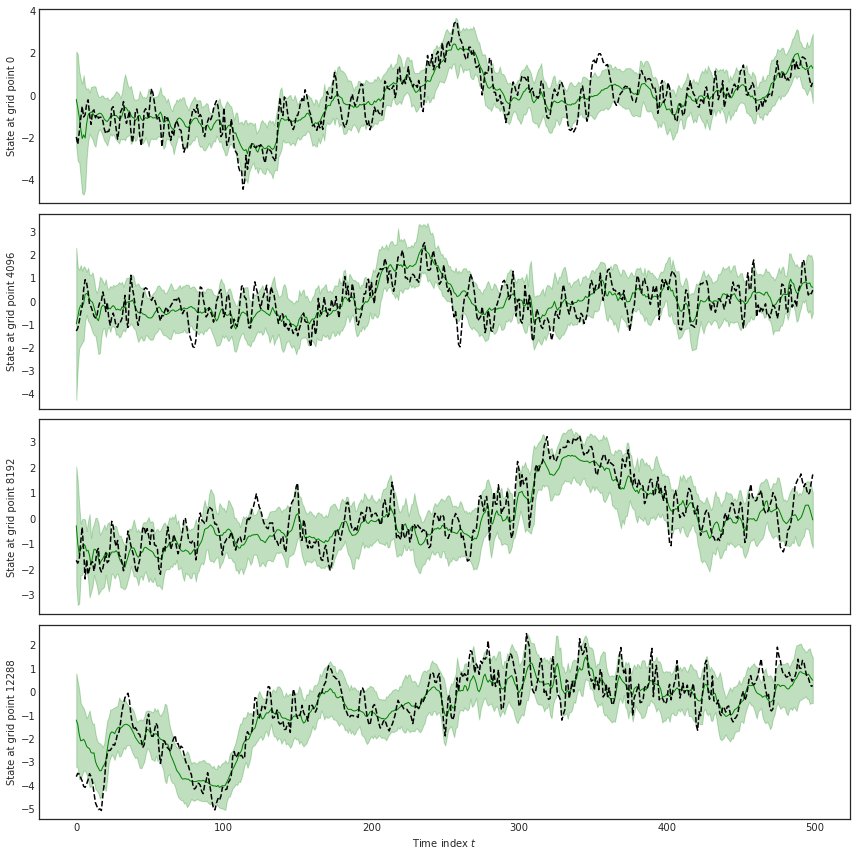

In [35]:
fig, axes = plot_results(
    results_sletpf_bl8, range(0, model.dim_z, model.dim_z // 4), z_reference)

In [36]:
anim, html = animate_fields(
    [z_reference, x_reference, results_sletpf_bl8['z_mean_seq']], 
    grid_shape, (12, 4), vmin=-3, vmax=3,
    save_path=base_file_path + '-sletpf-8x8.mp4',
    titles=['Unobserved vorticity and velocity fields',
            'Observed noisy subsampled vorticity field',
            'Estimated vorticity and velocity fields'])
html

### Block PoU (16x16)

In [37]:
pou_basis = pou.Blocked2dPartitionOfUnityBasis(grid_shape, (16, 16))
sletpf_bl16 = pf.PouLocalEnsembleTransportParticleFilter(
    model.init_state_sampler, model.next_state_sampler, rng,
    log_likelihood_per_obs_loc, localisation_kernel, pou_basis,
    ot_solver, ot_solver_params)

In [38]:
results_sletpf_bl16 = sletpf_bl16.filter(x_reference, 40, False)

Filtering: 100%|██████████| 500/500 [34:14<00:00,  4.11s/observation]


Mean RMSE: 0.501


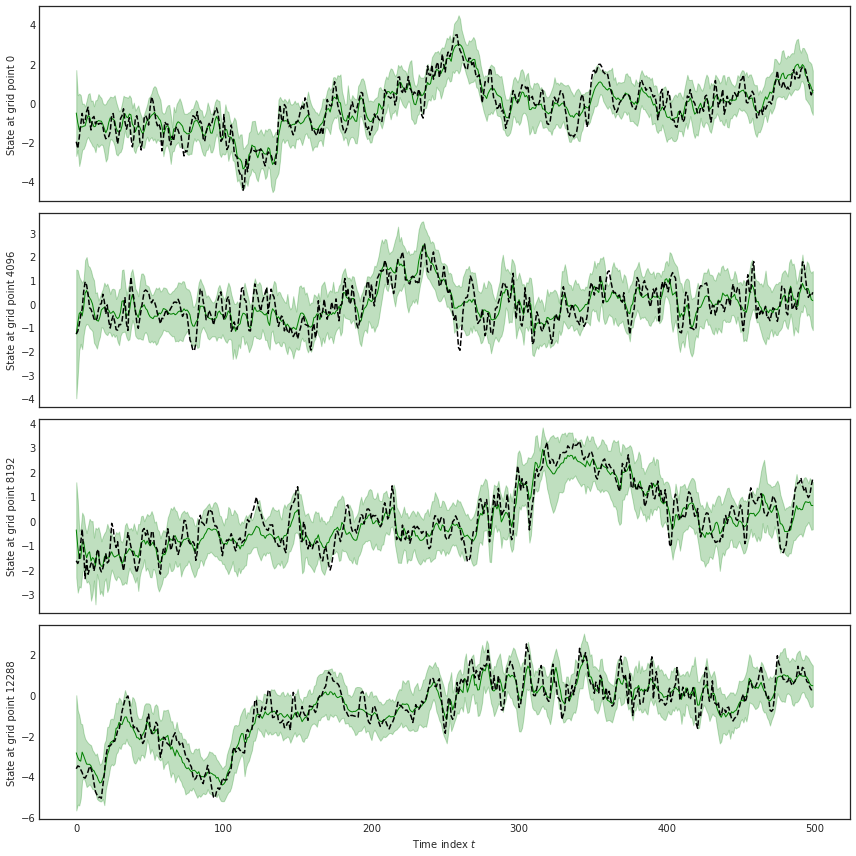

In [39]:
fig, axes = plot_results(
    results_sletpf_bl16, range(0, model.dim_z, model.dim_z // 4), z_reference)

In [40]:
anim, html = animate_fields(
    [z_reference, x_reference, results_sletpf_bl16['z_mean_seq']], 
    grid_shape, (12, 4), vmin=-3, vmax=3,
    save_path=base_file_path + '-sletpf-16x16.mp4',
    titles=['Unobserved vorticity and velocity fields',
            'Observed noisy subsampled vorticity field',
            'Estimated vorticity and velocity fields'])
html

### Block PoU (32x32)

In [41]:
pou_basis = pou.Blocked2dPartitionOfUnityBasis(grid_shape, (32, 32))
sletpf_bl32 = pf.PouLocalEnsembleTransportParticleFilter(
    model.init_state_sampler, model.next_state_sampler, rng,
    log_likelihood_per_obs_loc, localisation_kernel, pou_basis,
    ot_solver, ot_solver_params)

In [42]:
results_sletpf_bl32 = sletpf_bl32.filter(x_reference, 40, False)

Filtering: 100%|██████████| 500/500 [36:57<00:00,  4.43s/observation]


Mean RMSE: 0.455


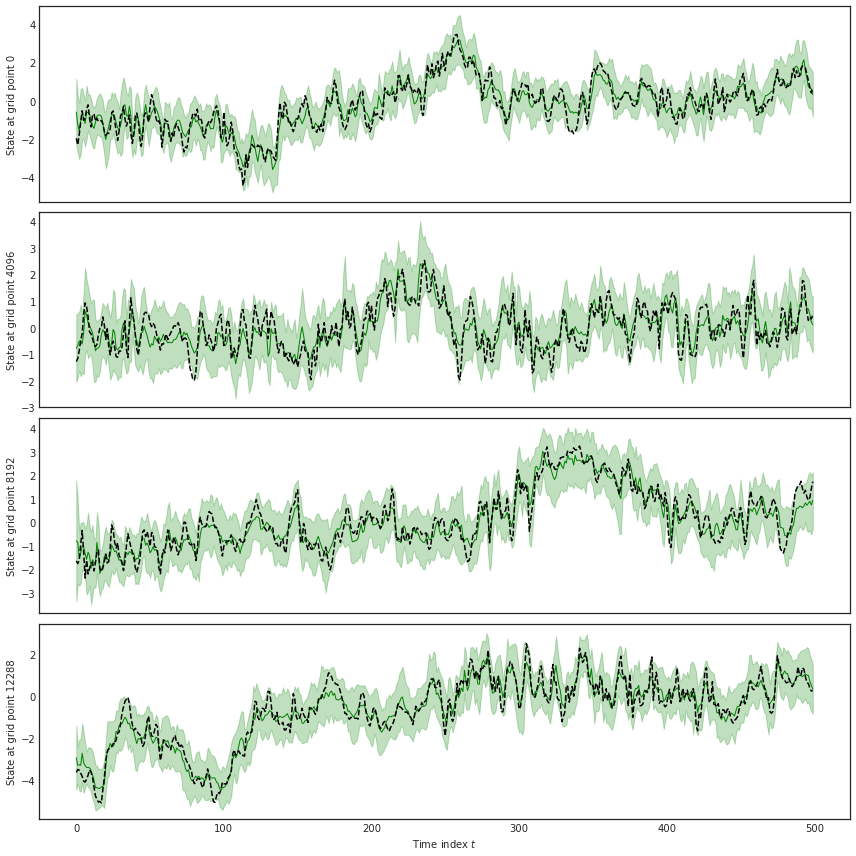

In [43]:
fig, axes = plot_results(
    results_sletpf_bl32, range(0, model.dim_z, model.dim_z // 4), z_reference)

In [44]:
anim, html = animate_fields(
    [z_reference, x_reference, results_sletpf_bl32['z_mean_seq']], 
    grid_shape, (12, 4), vmin=-3, vmax=3,
    save_path=base_file_path + '-sletpf-32x32.mp4',
    titles=['Unobserved vorticity and velocity fields',
            'Observed noisy subsampled vorticity field',
            'Estimated vorticity and velocity fields'])
html

### Square-cosine PoU (4x4)

In [ ]:
pou_basis = pou.SquaredCosine2dPartitionOfUnityBasis(grid_shape, (4, 4))
sletpf_sc4 = pf.PouLocalEnsembleTransportParticleFilter(
    model.init_state_sampler, model.next_state_sampler, rng,
    log_likelihood_per_obs_loc, localisation_kernel, pou_basis,
    ot_solver, ot_solver_params)

In [ ]:
results_sletpf_sc4 = sletpf_sc4.filter(x_reference, 40, False)

In [ ]:
fig, axes = plot_results(
    results_sletpf_sc4, range(0, model.dim_z, model.dim_z // 4), z_reference)

In [ ]:
anim, html = animate_fields(
    [z_reference, x_reference, results_sletpf_sc4['z_mean_seq']], 
    grid_shape, (12, 4), vmin=-3, vmax=3,
    save_path=base_file_path + '-sletpf-sc-4x4.mp4',
    titles=['Unobserved vorticity and velocity fields',
            'Observed noisy subsampled vorticity field',
            'Estimated vorticity and velocity fields'])
html

### Square-cosine PoU (8x8)

In [ ]:
pou_basis = pou.SquaredCosine2dPartitionOfUnityBasis(grid_shape, (8, 8))
sletpf_sc8 = pf.PouLocalEnsembleTransportParticleFilter(
    model.init_state_sampler, model.next_state_sampler, rng,
    log_likelihood_per_obs_loc, localisation_kernel, pou_basis,
    ot_solver, ot_solver_params)

In [ ]:
results_sletpf_sc8 = sletpf_sc8.filter(x_reference, 40, False)

In [ ]:
fig, axes = plot_results(
    results_sletpf_sc8, range(0, model.dim_z, model.dim_z // 4), z_reference)

In [ ]:
anim, html = animate_fields(
    [z_reference, x_reference, results_sletpf_sc8['z_mean_seq']], 
    grid_shape, (12, 4), vmin=-3, vmax=3,
    save_path=base_file_path + '-sletpf-sc-8x8.mp4',
    titles=['Unobserved vorticity and velocity fields',
            'Observed noisy subsampled vorticity field',
            'Estimated vorticity and velocity fields'])
html

### Square-cosine PoU (16x16)

In [ ]:
pou_basis = pou.SquaredCosine2dPartitionOfUnityBasis(grid_shape, (16, 16))
sletpf_sc16 = pf.PouLocalEnsembleTransportParticleFilter(
    model.init_state_sampler, model.next_state_sampler, rng,
    log_likelihood_per_obs_loc, localisation_kernel, pou_basis,
    ot_solver, ot_solver_params)

In [ ]:
results_sletpf_sc16 = sletpf_sc16.filter(x_reference, 40, False)

In [ ]:
fig, axes = plot_results(
    results_sletpf_sc16, range(0, model.dim_z, model.dim_z // 4), z_reference)

In [ ]:
anim, html = animate_fields(
    [z_reference, x_reference, results_sletpf_sc16['z_mean_seq']], 
    grid_shape, (12, 4), vmin=-3, vmax=3,
    save_path=base_file_path + '-sletpf-sc-16x16.mp4',
    titles=['Unobserved vorticity and velocity fields',
            'Observed noisy subsampled vorticity field',
            'Estimated vorticity and velocity fields'])
html